In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm,skew
from scipy import stats
import time

from sklearn.model_selection import KFold, cross_val_score,train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, LassoCV, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


In [3]:
df = pd.read_csv("./data/trainingData.csv")
pd.DataFrame(df.dtypes).rename(columns={0:'dtype'})

,dtype
Id,int64
city,object
age,int64
sex,object
social_class,object
primary_business,object
secondary_business,object
annual_income,float64
monthly_expenses,float64
old_dependents,int64


In [10]:
df.describe(include=[np.number])

,Id,age,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,occupants_count,house_area,sanitary_availability,water_availabity,loan_tenure,loan_installments,loan_amount
count,40000.00000,40000.00000,4.000000e+04,39880.000000,40000.000000,40000.00000,39621.000000,40000.000000,40000.000000,39792.000000,34747.000000,40000.000000,40000.000000,4.000000e+04
mean,20000.50000,55.15990,3.764021e+04,3810.875401,0.044900,1.13710,0.972489,26.641000,552.804750,0.686369,0.753216,12.032225,21.761175,8.412593e+03
std,11547.14972,3830.35566,2.873912e+04,4592.958009,0.222003,1.07384,0.163568,4749.995485,4596.921905,0.464028,0.255337,1.367473,16.682458,1.359694e+04
min,1.00000,2.00000,0.000000e+00,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3.000000,0.000000,1.000000e+02
25%,10000.75000,29.00000,1.440000e+04,2500.000000,0.000000,0.00000,1.000000,2.000000,200.000000,0.000000,0.500000,12.000000,12.000000,5.000000e+03
50%,20000.50000,35.00000,3.600000e+04,3500.000000,0.000000,1.00000,1.000000,3.000000,400.000000,1.000000,1.000000,12.000000,12.000000,8.000000e+03
75%,30000.25000,42.00000,5.600000e+04,4000.000000,0.000000,2.00000,1.000000,4.000000,600.000000,1.000000,1.000000,12.000000,50.000000,1.000000e+04
max,40000.00000,766105.00000,1.200000e+06,240000.000000,3.000000,7.00000,1.000000,950000.000000,700000.000000,1.000000,1.000000,84.000000,84.000000,1.343000e+06


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


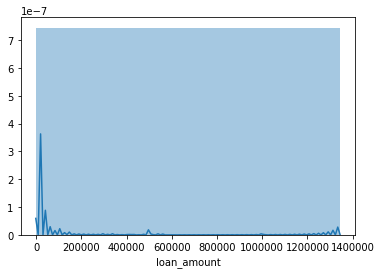

In [27]:
sns.distplot(df['loan_amount'], bins=1)
plt.show()

In [34]:
def outlier_treatment(datacolumn):
     sorted(datacolumn)
     Q1,Q3 = np.percentile(datacolumn , [25,75])
     IQR = Q3 - Q1
     lower_range = Q1 - (1.5 * IQR)
     upper_range = Q3 + (1.5 * IQR)
     return lower_range,upper_range

lowerbound,upperbound = outlier_treatment(df.loan_amount)

df[(df.loan_amount < lowerbound) | (df.loan_amount > upperbound)].shape

(203, 21)

In [35]:
#remove teh outlier

df.drop(df[ (df.loan_amount > upperbound) | (df.loan_amount < lowerbound) ].index , inplace=True)

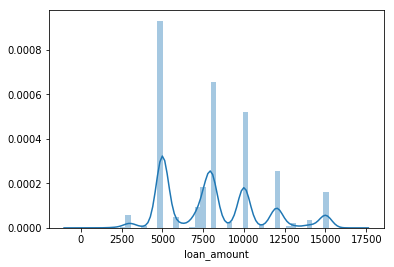

In [40]:
sns.distplot(df['loan_amount'])
plt.show()

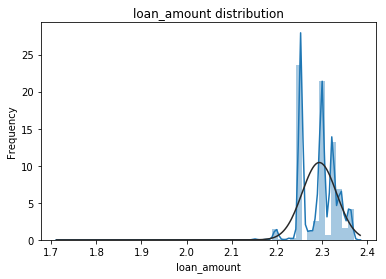

mu : 2.2944 and sigma : 0.0382


In [43]:
# log tranformation can be used to normalize the 
# positively/right skewed ditribution 

df["loan_amount"]= np.log1p(df["loan_amount"])

# new distribution
sns.distplot(df['loan_amount'], fit = norm)
plt.ylabel('Frequency')
plt.title('loan_amount distribution')
plt.show()

# Fitted paramter used by the function
mu,sigma = norm.fit(df['loan_amount'])
print(f"mu : {mu:.4f} and sigma : {sigma:.4f}")

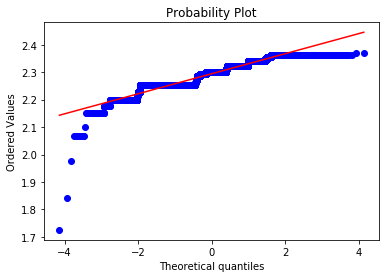

In [44]:
res = stats.probplot(df['loan_amount'], plot=plt)
plt.show()

In [45]:
#skewness and kurtosis
print("Skewness: %f" % df['loan_amount'].skew())
print("Kurtosis: %f" % df['loan_amount'].kurt())

Skewness: -0.385056
Kurtosis: 1.609675


In [53]:
# Missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
social_class,5254,0.132020
water_availabity,5252,0.131970
secondary_business,5240,0.131668
city,1826,0.045883
type_of_house,694,0.017439
home_ownership,379,0.009523
sanitary_availability,208,0.005227
monthly_expenses,120,0.003015
loan_purpose,26,0.000653
primary_business,26,0.000653


In [54]:
for col in ['primary_business', 'secondary_business']:
    df[col]=df[col].fillna('none')

In [55]:
# There has to be purpose for the loan
# Missing values can specified as others
df['loan_purpose'] = df['loan_purpose'].fillna('Others')

In [56]:
df = df.drop(df[df['occupants_count'] >= 100].index)
df.loc[df.water_availabity == -1, 'water_availabity'] = 1
df.loc[df.sanitary_availability == -1, 'sanitary_availability'] = 1

In [57]:
# Continous feature - House area
df['house_area_band']=0
df.loc[df.house_area == 0, 'house_area_band'] = 0
df.loc[(df.house_area > 0) & (df.house_area <= 250), 'house_area_band'] = 1
df.loc[(df.house_area > 250) & (df.house_area <= 500), 'house_area_band'] = 2
df.loc[(df.house_area > 500) & (df.house_area <= 750), 'house_area_band'] = 3
df.loc[(df.house_area > 750) & (df.house_area <= 1000), 'house_area_band'] = 4
df.loc[(df.house_area > 1000) & (df.house_area <= 2000), 'house_area_band'] = 5
df.loc[df.house_area > 2000, 'house_area_band'] = 6

In [58]:
# Data imputation for house_owership for null values 
# if house area is grater than 2000 applicant own thier house
# If the house area is 0 then home_ownership can be considered as 0

df.loc[(df['home_ownership'].isnull()) & (df['house_area'] > 2000), 'home_ownership'] = 1
df.loc[(df['home_ownership'].isnull()) & (df['house_area'] == 0), 'home_ownership'] = 0

In [59]:
# If the occupant count is 0 then there is sanitary_availability is 0
# Data imputation for sanitary availability 

df.loc[(df['sanitary_availability'].isnull()) & (df['occupants_count'] == 0), 'sanitary_availability'] = 0

In [60]:
# most of the owned houses are T1 ans T2 
# Means of type is almost same irrespective of the occupant count 
# types_of_house which are missing for which there is no sanitary availability
# water availability is unknow
df.groupby('type_of_house').agg({'occupants_count': ['mean', 'min', 'max']})


df[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0)].shape[0] 
# Changes of having only room is high fill the data by mode
df[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1)].shape[0]
# changes of having T1 and T2 is high compair to R

pd.crosstab([df.sanitary_availability,
            df.type_of_house],
            df.home_ownership,
            margins=True)\
.style.background_gradient(cmap='summer_r')

df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0) ,
       'type_of_house'] =df[(df['sanitary_availability'] == 0) & (df['home_ownership']==0)].type_of_house.mode()[0]
df.loc[(df['type_of_house'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1) ,
       'type_of_house'] =df[(df['sanitary_availability'] == 0) & (df['home_ownership']==1)].type_of_house.mode()[0]

In [61]:
# imputation for water availability 
# if they applicant owns house then most likely to have water availability wither full or half taking the mode of the water avaibility

df.loc[(df['water_availabity'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==0), 
       'water_availabity'] = df[(df['sanitary_availability'] == 0) & (df['home_ownership']==0)].water_availabity.mode()[0]

df.loc[(df['water_availabity'].isnull()) & (df['sanitary_availability'] == 0) & (df['home_ownership']==1), 
       'water_availabity'] = df[(df['sanitary_availability'] == 0) & (df['home_ownership']==1)].water_availabity.mode()[0]


In [62]:
# Analysis for city
# Most likly to drop this column
df.groupby('city').size().reset_index(name='counts')
df['city'] = df['city'].fillna('Unknow')

In [63]:
# Total occupant and Monthly expenses 
df['total_dependents'] = df['old_dependents'] + df['young_dependents']

# Conclusion - 
# As number of dependent increases monthly expenses increases
# Monthly expenses are higher for applicant who don't own house
# Monthly expenses are less for T2 types of house as most of the T2 houses are owned 
# filling the missing values with mean of the monthly expenses 

df['monthly_expenses'] = df['monthly_expenses'].fillna(df['monthly_expenses'].mean())

In [64]:
df = df.drop(df[df['age'] >= 70].index)
df = df.drop(df[df['age'] < 18].index)

In [65]:
# Changeing the string values to numeric
df['sex'].replace(['F', 'M', 'TG'], [0,1,2], inplace=True)
df['type_of_house'].replace(['R', 'T1', 'T2'], [0,1,2], inplace=True)
df.loc[~df['primary_business'].isin(['none']), 'primary_business'] = 1
df.loc[df['primary_business'].isin(['none']), 'primary_business'] = 0
df.loc[~df['secondary_business'].isin(['none']), 'secondary_business'] = 1
df.loc[df['secondary_business'].isin(['none']), 'secondary_business'] = 0
df.loc[~df['loan_purpose'].isin(['none']), 'loan_purpose'] = 1
df.loc[df['loan_purpose'].isin(['none']), 'loan_purpose'] = 0

In [66]:
# Feature Engineering
# Determine the skewness in numerical parameters
numeric_features=df.dtypes[df.dtypes !="object"].index

#calculate skewness using lambda functions
skewed_features = df[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.80]
skewed_features = skewed_features.index

df[skewed_features] = np.log1p(df[skewed_features])

In [69]:
# Preparing data set for training
X= df.drop(['Id', 'city', 'loan_amount', 'social_class', 'house_area'], axis=1).values
y= df['loan_amount'].values

# Split the data into train and val sets

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20,random_state=42)

In [70]:
# KFold cross validation 

n_folds = 5
def rmse_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, 
                                    scoring="neg_mean_squared_error", 
                                    cv=kf))
    return rmse

n_folds = 5
custom_cv = KFold(n_folds, shuffle=True, random_state=42)

def print_model_stats(model):
    print("Training RMSE : %.4f" % rmse_cv(model).mean())
    print("Validation R^2 : %.4f" % r2_score(y_val, model.predict(X_val)))
    print("Validation RMSE : %.4f" % mean_squared_error(y_val, model.predict(X_val)))
    print("Validation Mean Absolute Error: %.4f" % mean_absolute_error(y_val,model.predict(X_val)))

In [78]:
# Predictive Models
# GradientBoostingRegressor
start_time = time.time()

GBR_model = GradientBoostingRegressor(n_estimators=3000,
                               learning_rate = 0.05,
                               max_depth = 4,
                               max_features = 'sqrt',
                               min_samples_leaf = 15,
                               min_samples_split=10,
                               loss='huber', 
                               random_state=5)

history = GBR_model.fit(X_train, y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(GBR_model)

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['cosine_proximity'])
plt.show()

Training time : 44.9048  seconds
Training RMSE : 0.0240
Validation R^2 : 0.6026
Validation RMSE : 0.0006
Validation Mean Absolute Error: 0.0173


AttributeError: 'GradientBoostingRegressor' object has no attribute 'history'

In [76]:
#random forest regressor

start_time = time.time()
RFR_model = RandomForestRegressor(min_samples_leaf=2,
                                 min_samples_split=2,
                                 max_features='sqrt',
                                 max_depth=50,
                                 bootstrap=False,
                                 n_estimators=800)
RFR_model.fit(X_train,y_train)
print("Training time : %.4f" % (time.time() - start_time), " seconds")
print_model_stats(RFR_model)

tree_small = RFR_model.estimators_[5]
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

Training time : 21.5156  seconds
Training RMSE : 0.0235
Validation R^2 : 0.6234
Validation RMSE : 0.0006
Validation Mean Absolute Error: 0.0164
